The objective of this project is to predict whether the individuals who boarded the Titanic from the test dataset had survived or not. Also, attempts have been made to find out what the data tell us about the shipwreck with the help of a Decision Classification Tree. 

In [36]:
# importing necessary libraries
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Storing test passenger IDs for easy access
PassengerId = test['PassengerId']

In [4]:
# Preview of the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Processing the dataset

In [5]:
# Making an original copy of the dataset
original_train = train.copy()

In [6]:
# Combining train and test datasets
full_data = [train, test]

In [7]:
# Feature that tells whether a passenger had a cabin booked on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [9]:
# To find the family size, a new feature is created combining Sibsp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [10]:
# Creating a new faeture IsAlone from the family size
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [11]:
# Removing all NULLS in the Embarked and Fare columns
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [12]:
# Filling null values of age using Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

for dataset in full_data:
    d = pd.DataFrame(dataset['Age'])
    imputer = IterativeImputer(random_state=42)
    imp_d = imputer.fit_transform(d)
    dataset['Age'] = pd.DataFrame(imp_d)
    dataset['Age']= dataset['Age'].astype(int)

In [13]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [14]:
   # Mapping Sex and titles
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [15]:
# Mapping Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    

In [16]:
# Mapping Age
for dataset in full_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

In [17]:
# Feature selection - Removing variables no longer needed
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Visualising processed data

In [18]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


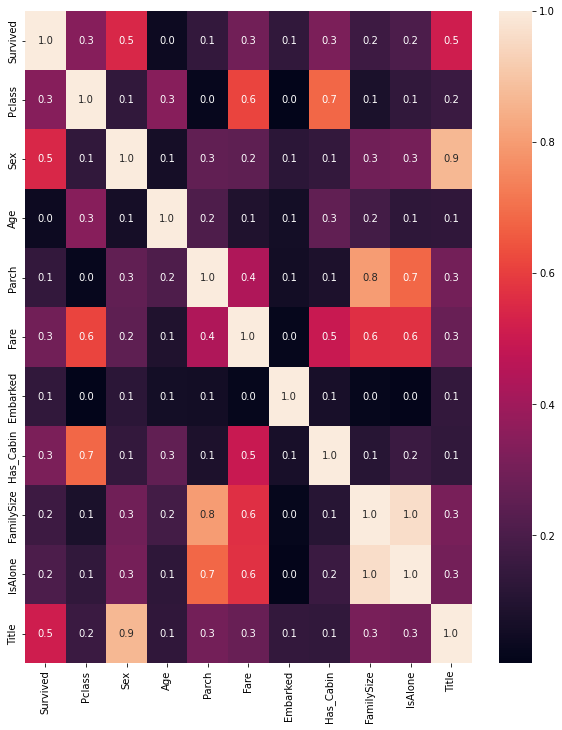

In [19]:
# Using spearman heat map to visualise the correlations between different features
corrmatrix =train.corr(method='spearman')
fig, ax=plt.subplots(figsize=(10,12))
sns.heatmap(abs(corrmatrix),annot=True,fmt='.1f')
plt.show()

This heatmap provides an initial observation as we can easily see the correlation between each feature. In this case, Sex and Title show the highest correlations 0.9 (in absolute terms) and with the class (Survived): both show 0.5. So they are probably carrying the same information and using the two as inputs for the same model may reduce accuracy. High chances are one of them will be used for the first node in our final decision tree, so these features are explored further and compared.

### Feature recognition

You can easily compare features and their relationship with the class by grouping them and calculating some basic statistics for each group. The code below does exactly this in one line, and explains the meaning of each metric when working with a binary class.

In [20]:
# Title
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [21]:
# Sex
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}}


Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

The data shows that less 'Mr' survived (15.67%) than men in general (18.89%): Title seems therefore to be more useful than Sex for our purpose. This may be because Title implicitly includes information about Sex in most cases. To verify this, we can use the copy we made of the original training data without mappings and check the distribution of Sex grouped by Title.

In [22]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

It is found that, excepting for a single observation (a female with 'Dr' title), all the observations for a given Title share the same Sex. Therefore the feature Title is capturing all the information present in Sex. In addition, Title may be more valuable to our task by capturing other characteristics of the individuals like age, social class, personality, etc.

It's true that by regrouping rare titles into a single category, some information are lost regarding Sex. We could create two categories "Rare Male" and "Rare Female", but the separation will be almost meaningless due to the low occurrence of "Rare" Titles (2.6%, 23 out of 891 samples).

Because of this in-depth analysis of the Sex and Title features, even if the correlation of the feature Sex with the class Survived was higher, Title is a richer feature because it carries the Sex information but also adds other characteristics. Therefore is very likely that Title is going to be the first feature in the final decision tree, making Sex useless after this initial split.

## Gini Impurity

The goal of the learning algorithms is always to find the best split for each node of the tree. But for measuring the "goodness" of a given different metrics are used for evaluating splits. Some commonly used metrics are Information Gain, Gini Impurity,etc.

Gini Impurity measures the disorder of a set of elements. It is calculated as the probability of mislabelling an element assuming that the element is randomly labelled according the the distribution of all the classes in the set. Decision Trees will try to find the split which decreases Gini Impurity the most across the two resulting nodes.

In [23]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Let's use our Sex and Title features as an example and calculate how much each split will decrease the overall weighted Gini Impurity. First, we need to calculate the Gini Impurity of the starting node including all 891 observations in our train dataset. Since only 342 observations survived, the survival probability is around 38.38% (342/891).

In [24]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

We're now going to simulate both splits, calculate the impurity of resulting nodes and then obtain the weighted Gini Impurity after the split to measure how much each split has actually reduced impurity.

If we split by Sex, we'll have the two following nodes:

Node with men: 577 observations with only 109 survived
Node with women: 314 observations with 233 survived

In [25]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [26]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [27]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

If we split by Title == 1 (== Mr), we'll have the two following nodes:

Node with only Mr: 517 observations with only 81 survived
Node with other titles: 374 observations with 261 survived

In [28]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [29]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [30]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

We find that the Title feature is slightly better at reducing the Gini Impurity than Sex. This confirms our previous analysis, and we're now sure that Title will be used for the first split. Sex will therefore be neglected since the information is already included in the Title feature. 

## Decision Tree Depth using Cross Validation

In the case of decision trees, the 'max_depth' parameter determines the maximum number of attributes the model is going to use for each prediction (up to the number of available features in the dataset). A good way to find the best value for this parameter is just iterating through all the possible depths and measure the accuracy with a robust method such as Cross Validation.

In [31]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)


# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.814831
         6          0.808127
         7          0.811461
         8          0.810362
         9          0.813733
        10          0.806991


It can be seen that the max depth of 3 gives the highest average accuracy value (82.8% average accuracy across the 10 folds). This can be justified by the fact that feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 3 as the max_depth parameter for our final model.

In [61]:
train_features=[]
for col in train.columns:
    train_features.append(str(col))
train_features = train_features[1:]

## Decision tree model

[Text(0.5, 0.875, 'X[9] <= 1.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(0.25, 0.625, 'X[6] <= 0.5\ngini = 0.264\nsamples = 517\nvalue = [436, 81]'),
 Text(0.125, 0.375, 'X[0] <= 1.5\ngini = 0.197\nsamples = 424\nvalue = [377, 47]'),
 Text(0.0625, 0.125, 'gini = 0.351\nsamples = 22\nvalue = [17, 5]'),
 Text(0.1875, 0.125, 'gini = 0.187\nsamples = 402\nvalue = [360, 42]'),
 Text(0.375, 0.375, 'X[4] <= 0.5\ngini = 0.464\nsamples = 93\nvalue = [59, 34]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.4375, 0.125, 'gini = 0.48\nsamples = 85\nvalue = [51, 34]'),
 Text(0.75, 0.625, 'X[7] <= 4.5\ngini = 0.422\nsamples = 374\nvalue = [113, 261]'),
 Text(0.625, 0.375, 'X[0] <= 2.5\ngini = 0.346\nsamples = 323\nvalue = [72, 251]'),
 Text(0.5625, 0.125, 'gini = 0.215\nsamples = 196\nvalue = [24, 172]'),
 Text(0.6875, 0.125, 'gini = 0.47\nsamples = 127\nvalue = [48, 79]'),
 Text(0.875, 0.375, 'X[0] <= 2.5\ngini = 0.315\nsamples = 51\nvalue = [41, 10]'),
 

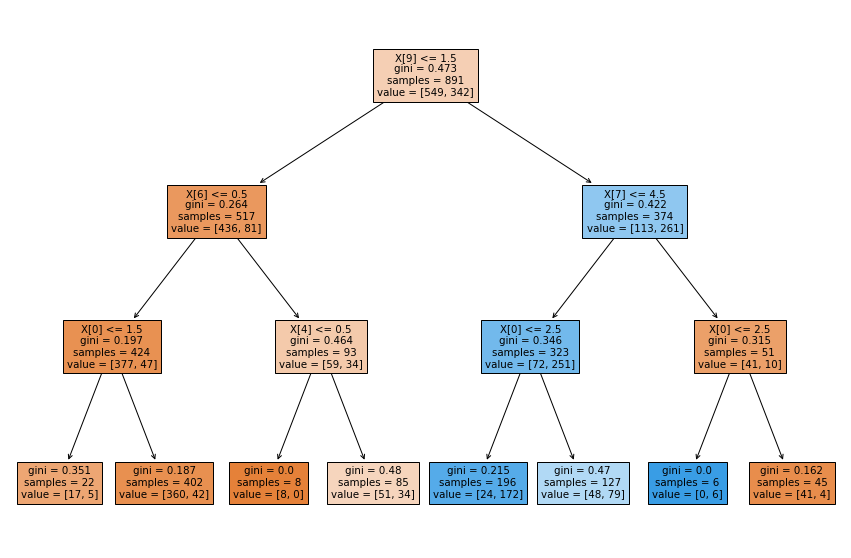

In [64]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.png", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = train_features,
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)   

In [33]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38